## Regression 실습 - 자전거 대여 수요 예측
### 데이터 클렌징 및 가공

In [10]:
import warnings
warnings.filterwarnings(action='ignore')

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
bike_df = pd.read_csv('../data/bike_train.csv')
print(bike_df.shape)
bike_df.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


#### 2011년 1월 ~ 2012년 12월
* 날짜,/시간, 기온, 습도, 풍속 등의 정보를 기반으로 1시간 간격 동안의 자전거 대여 횟수가 기재되어 있음<br>
* datetime: hourly date + timestamp  
* season: 1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울  
* holiday: 1 = 토, 일요일의 주말을 제외한 국경일 등의 휴일, 0 = 휴일이 아닌 날  
* workingday: 1 = 토, 일요일의 주말 및 휴일이 아닌 주중, 0 = 주말 및 휴일  
* weather:  
    1 = 맑음, 약간 구름 낀 흐림  
    2 = 안개, 안개 + 흐림  
    3 = 가벼운 눈, 가벼운 비 + 천둥  
    4 = 심한 눈/비, 천둥/번개  
* temp: 온도(섭씨)   
* atemp: 체감온도(섭씨)  
* humidity: 상대습도  
* windspeed: 풍속  
* casual: 사전에 등록되지 않는 사용자가 대여한 횟수  
* registered: 사전에 등록된 사용자가 대여한 횟수  
* count: 대여 횟수  

In [12]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [13]:
# 문자열을 datetime 타입으로 변경. 
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [14]:
# datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x: x.hour)
print(bike_df.info())
bike_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  year        10886 non-null  int64         
 13  month       10886 non-null  int64         
 14  day         10886 non-null  int64         
 15  hour        10886 non-null  int64         
dtypes: datetime64[ns](1), 

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


In [15]:
#casual+registered 정보는 count에 있으므로 삭제
drop_columns = ['datetime','casual','registered']
bike_df.drop(drop_columns, axis=1,inplace=True)

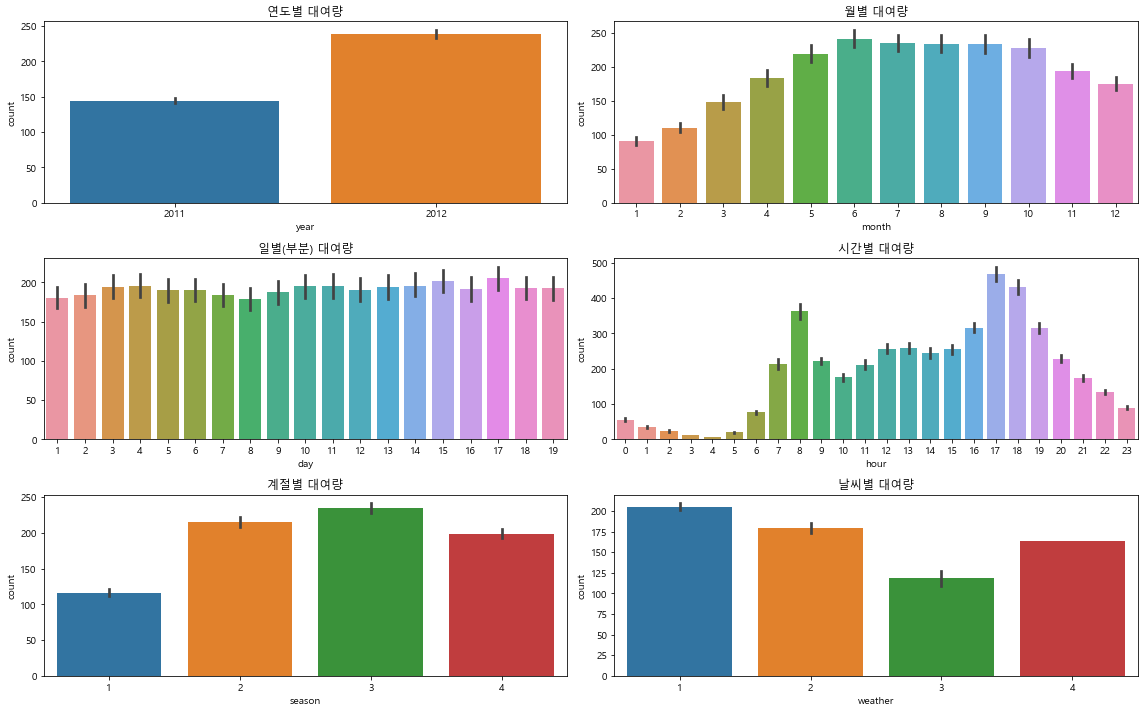

In [16]:
figure, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2)
figure.set_size_inches(16,10)

sns.barplot(data=bike_df, x="year", y="count", ax=ax1)
sns.barplot(data=bike_df, x="month", y="count", ax=ax2)
sns.barplot(data=bike_df, x="day", y="count", ax=ax3)
sns.barplot(data=bike_df, x="hour", y="count", ax=ax4)
sns.barplot(data=bike_df, x="season", y="count", ax=ax5)
sns.barplot(data=bike_df, x="weather", y="count", ax=ax6)

ax1.set(title="연도별 대여량")
ax2.set(title="월별 대여량")
ax3.set(title="일별(부분) 대여량")
ax4.set(title="시간별 대여량")
ax5.set(title="계절별 대여량")
ax6.set(title="날씨별 대여량")
plt.tight_layout()

### 로그 변환, 피처 인코딩, 모델 학습/예측/평가 
* https://www.kaggle.com/c/bike-sharing-demand/overview/evaluation
* RMSLE(실제 값과 예측값의 오류를 로그로 변환한 뒤 RMSE를 적용) 
* Score : RMSLE(Root Mean Squared Logarithmic Error), 과대평가된 항목보다 과소평가 된 항목에 페널티를 준다. 0에 가까울 수록 정밀도가 높다.

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    mse_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MSE: {2:.3F}'.\
          format(rmsle_val, rmse_val, mse_val))

In [18]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression , Ridge , Lasso
y_target = bike_df['count']
X_features = bike_df.drop(['count'],axis=1,inplace=False)
X_train, X_test, y_train, y_test = train_test_split(\
                            X_features, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test ,pred)

RMSLE: 1.165, RMSE: 140.900, MSE: 105.924


In [19]:
def get_top_error_data(y_test, pred, n_tops = 5):
    # DataFrame에 컬럼들로 실제 대여횟수(count)와 예측 값을 서로 비교 할 수 있도록 생성. 
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count']= np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    # 예측값과 실제값이 가장 큰 데이터 순으로 출력. 
    print(result_df.sort_values('diff', ascending=False)[:n_tops])
    
get_top_error_data(y_test,pred,n_tops=5)


      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


<AxesSubplot:>

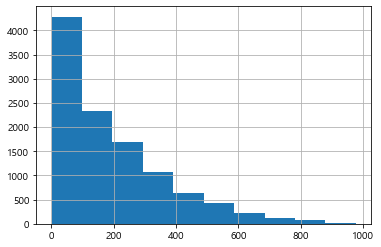

In [20]:
#0~200 사이에 데이터가 왜곡돼 있음.
y_target.hist()

<AxesSubplot:>

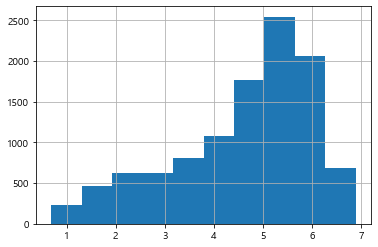

In [21]:
# 왜곡된 값을 정규 분포 형태로 바꿈 - 왜곡이 좀 향상됨
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

In [22]:
# 타겟 컬럼인 count 값을 log1p 로 Log 변환
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영하여 학습/테스트 데이터 셋 분할
X_train, X_test, y_train, y_test = train_test_split(\
                        X_features, y_target_log, test_size=0.3, random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 셋의 Target 값은 Log 변환 --> 다시 expm1를 이용하여 원래 scale로 변환
y_test_exp = np.expm1(y_test)

# 예측 값 역시 Log 변환된 타겟 기반으로 학습되어 예측되었으므로 다시 exmpl으로 scale변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp ,pred_exp)

RMSLE: 1.017, RMSE: 162.594, MSE: 109.286


* 이전=> RMSLE: 1.165, RMSE: 140.900, MSE: 105.924
* RMSLE 오류는 줄었지만, RMSE, MSE는 오히려 늘었다.

In [50]:
pred #로그로 변환된 값

array([5.7353795 , 5.08865258, 4.99393205, ..., 5.86621689, 5.03923437,
       4.31986653])

In [53]:
y_test 

6638     5.501258
7975     5.480639
5915     5.438079
8050     6.148468
5894     5.817111
           ...   
5521     1.791759
10626    2.564949
8126     4.317488
1633     4.143135
6198     5.153292
Name: count, Length: 3266, dtype: float64

In [54]:
y_test_exp

6638     244.0
7975     239.0
5915     229.0
8050     467.0
5894     335.0
         ...  
5521       5.0
10626     12.0
8126      74.0
1633      62.0
6198     172.0
Name: count, Length: 3266, dtype: float64

In [55]:
pred_exp

array([308.63045453, 161.17120235, 146.5153226 , ..., 351.91134842,
       153.35179351,  74.17859374])

<AxesSubplot:>

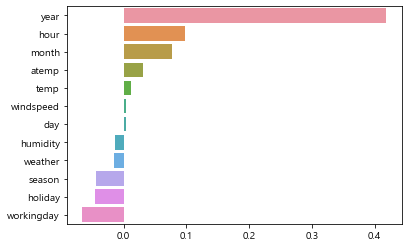

In [23]:
#피처 중요도
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

* 각 피처의 회귀 계수 값을 시각화-year(2011,2012)피처의 회귀 계수 값이 독보적으로 크다.
* 날씨, 계절, 시간.. 대여 횟수에 영향을 주지만 but year는 
* year 피처는 연도를 뜻하므로 카테고리형 피처지만 숫자값으로 돼 있어 이것을 One Hot Encoding 적용 
* 숫자형 카테고리 값을 선형 회귀에 사용할 겨우 회귀 계수를 연산하 때 이 숫자형 값에 크게 영향을 받는 경우가 발생하므로 주의

In [24]:
X_features_ohe = pd.get_dummies(X_features, columns=['year','month','hour', 'holiday',
                                              'workingday','season','weather'])

In [58]:
X_features_ohe.head()

,temp,atemp,humidity,windspeed,day,year_2011,year_2012,month_1,month_2,month_3,...,workingday_0,workingday_1,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,9.84,14.395,81,0.0,1,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
1,9.02,13.635,80,0.0,1,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
2,9.02,13.635,80,0.0,1,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
3,9.84,14.395,75,0.0,1,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
4,9.84,14.395,75,0.0,1,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0


In [25]:
# 원-핫 인코딩이 적용된 feature 데이터 세트 기반으로 학습/예측 데이터 분할. 
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log,
                                                    test_size=0.3, random_state=0)
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred) 

# model 별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model,X_train, X_test, y_train, y_test,is_expm1=True)

### LinearRegression ###
RMSLE: 0.589, RMSE: 97.484, MSE: 63.106
### Ridge ###
RMSLE: 0.589, RMSE: 98.407, MSE: 63.648
### Lasso ###
RMSLE: 0.634, RMSE: 113.031, MSE: 72.658


* 이전 : RMSLE: 1.017, RMSE: 162.594, MSE: 109.286
* 선형 회귀 수행 시 - 피처를 어떻게 인코딩 하는가가 성능에 중요한 영향을 미칠 수 있다.

<AxesSubplot:>

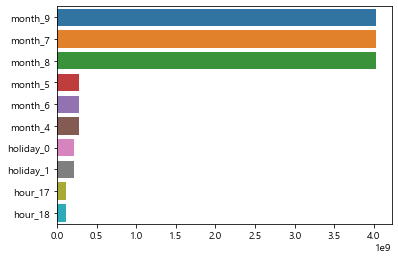

In [59]:
# month_10, month_11, month_12, weather_1..등의 피처 회귀 계수가 높게 나왔다.
coef = pd.Series(lr_reg.coef_ , index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:10]
sns.barplot(x=coef_sort.values , y=coef_sort.index)

In [27]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# RF, GBM, XGBoost, LightGBM model 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    get_model_predict(model,X_train, X_test, y_train, y_test,is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.354, RMSE: 50.991, MSE: 31.616
### GradientBoostingRegressor ###
RMSLE: 0.340, RMSE: 55.802, MSE: 34.352
### XGBRegressor ###
RMSLE: 0.339, RMSE: 50.950, MSE: 30.891
### LGBMRegressor ###
RMSLE: 0.316, RMSE: 46.473, MSE: 28.777


* 회귀 트리를 이용해 회귀 예측을 수행 ==> 선형 회귀 모델보다 회귀 예측 성능이 개선됨. 
* 데이터 세트의 유형에 따라 결과는 달라질 수 있음.

In [61]:
lasso_pred = gbm_reg.predict(X_test)

ValueError: Expected 2D array, got 1D array instead:
array=[244. 239. 229. ...  74.  62. 172.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [60]:
lasso_pred 

array([5.24524512, 5.34118926, 5.09296211, ..., 4.63563746, 4.18755914,
       4.73016176])

In [46]:
lgbm_reg = gbm_reg(X_test)

TypeError: 'GradientBoostingRegressor' object is not callable

In [47]:
submission = pd.read_csv("../data/sampleSubmission.csv")

In [48]:
submission['count']  = lgbm_reg

In [49]:
submission.head()

,datetime,count
0,2011-01-20 00:00:00,LGBMRegressor(n_estimators=500)
1,2011-01-20 01:00:00,LGBMRegressor(n_estimators=500)
2,2011-01-20 02:00:00,LGBMRegressor(n_estimators=500)
3,2011-01-20 03:00:00,LGBMRegressor(n_estimators=500)
4,2011-01-20 04:00:00,LGBMRegressor(n_estimators=500)
